In [56]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset,concatenate_datasets
import transformers
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, DataCollatorWithPadding,RobertaForSequenceClassification,AdamW,get_scheduler,TrainingArguments,Trainer

from src.utils.myutils import *


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

DATA_PATH = PATH + '/data/CS/raw/WIKI2-CS'

model_checkpoint = 'ufal/robeczech-base'
BATCH_SIZE = 32
transformers.utils.logging.set_verbosity_error()


In [57]:
train = load_dataset('csv',data_files=DATA_PATH+"/biased-unbiased-6k.csv")['train']
#train = load_dataset('csv',data_files=DATA_PATH+"/wordbiased-unbiased-3.5k.csv")['train']
babe_cs = load_dataset('csv',data_files=PATH + '/data/CS/processed/BABE/babe_sg2_cs.csv')['train']

Using custom data configuration default-caacc86a85770cd3
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-caacc86a85770cd3/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-a2670560b441305b
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-a2670560b441305b/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


## training

In [59]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False,padding=True) #fast tokenizer is buggy in RoBERTa models
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint)
model.to(device);

In [60]:
train_tokenized = preprocess_data(train,tokenizer,'sentence')
babe_tokenized = preprocess_data(babe_cs,tokenizer,'sentence')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/csv/default-caacc86a85770cd3/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-ee7c87e64ed6bc54.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/csv/default-a2670560b441305b/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-0a98363308a6254f.arrow


In [61]:
training_args = TrainingArguments(
    num_train_epochs=4,
    per_device_train_batch_size=BATCH_SIZE,  
    #per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=50,
    disable_tqdm = False,
    warmup_steps=50,
    save_total_limit=2,
    #load_best_model_at_end=True,
    #evaluation_strategy="steps",
    metric_for_best_model = 'f1',
    weight_decay=0.05,
    output_dir = './',
    learning_rate=4e-5)

## BEST PARAMS

In [62]:
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint);
trainer = Trainer(model,training_args,train_dataset=train_tokenized,data_collator=data_collator,
                      tokenizer=tokenizer)
trainer.train()

***** Running training *****
  Num examples = 6108
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 764


Step,Training Loss
50,0.695900
100,0.652800
150,0.485800
200,0.477300
250,0.422400
300,0.448400
350,0.429000
400,0.406300
450,0.400800
500,0.397500


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
Deleting older checkpoint [checkpoint-3000] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=764, training_loss=0.43631842997685777, metrics={'train_runtime': 159.442, 'train_samples_per_second': 153.234, 'train_steps_per_second': 4.792, 'total_flos': 1221051130158000.0, 'train_loss': 0.43631842997685777, 'epoch': 4.0})

In [63]:
test_dataloader = DataLoader(babe_tokenized, batch_size=BATCH_SIZE, collate_fn=data_collator)
compute_metrics(model,device,test_dataloader)

{'f1': 0.6645793629185952}

In [64]:
preds = torch.Tensor([]).to(device)

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds = torch.cat((preds,logits),0)

Confusion matrix, without normalization
[[1242  621]
 [ 611 1199]]


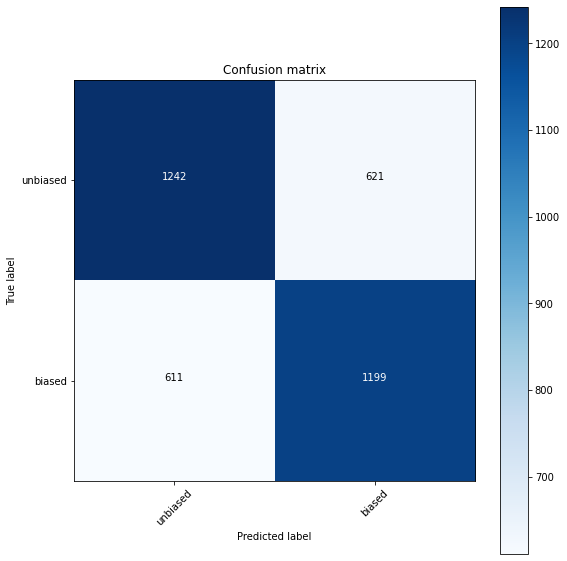

In [65]:
labels = babe_tokenized['label']
preds = F.softmax(preds,dim=1).argmax(dim=1)

cm = confusion_matrix(labels,preds.cpu())
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,['unbiased','biased'])